In [1]:
from pandas import read_csv
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
%matplotlib inline

Q:\swtools\python\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Q:\swtools\python\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Example 1

The function _read_\__csv()_ supports reading data directly from the URLs, and this is illusrtaed below on the [Pima dataset][pid].

[pid]: https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes "Pima Indian Diabetes Dataset"

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-\
databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 
         'test', 'mass', 'pedi', 'age', 'class']
data = read_csv(url, names=names)
data.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
X = data.drop('class', axis=1)
y = data['class']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, random_state=0)

## Simple usage example

### Without pipeline

#### Data transformations

We wish to apply three sequential transformers to the data.

In [5]:
scaler = StandardScaler()
selector = SelectKBest(k=5)
pca_transformer = PCA(n_components=2)

In [6]:
X_train_2 = scaler.fit(X_train, y_train).transform(X_train)
X_train_3 = selector.fit(X_train_2, y_train).transform(X_train_2)
X_train_4 = pca_transformer.fit(X_train_3, y_train).transform(X_train_3)

In [9]:
X_train_4[:5, :]

array([[-0.73501192,  1.60159189],
       [-1.63758412, -0.88941534],
       [-0.61450044,  0.47240821],
       [ 2.31288416,  0.23199593],
       [ 0.36103144,  0.07167293]])

In [11]:
y_train.value_counts()

0    343
1    194
Name: class, dtype: int64

#### Modelling

Next, we wish to apply a classifier on the transformed data.

In [12]:
dt_clf = DecisionTreeClassifier(max_depth=2, class_weight='balanced')

In [13]:
def show_results(scores):
    print scores
    print "Mean:", scores.mean()
    print "Std:", scores.std()
    print 

In [14]:
scores = cross_val_score(dt_clf, X_train_4, y_train, scoring='f1', cv=10)
show_results(scores)

[ 0.63157895  0.66666667  0.63829787  0.62962963  0.65306122  0.62857143
  0.55813953  0.59259259  0.6         0.57142857]
Mean: 0.616996646797
Std: 0.0333957649194



#### Final validation

In order to make a prediction for the test data, **we have to apply to the test data the same transformations**.

In [15]:
X_test_2 = scaler.transform(X_test)
X_test_3 = selector.transform(X_test_2)
X_test_4 = pca_transformer.transform(X_test_3)

Finally we can make a prediction and see our model's score for the test data.

In [18]:
y_pred = dt_clf.fit(X_train_4, y_train).predict(X_test_4)
f1_score(y_true=y_test, y_pred=y_pred)

0.61146496815286622

### With pipeline

The pipeline allows us to define a "chain" of transformers (and potentially an estimator at the end), which work as a single unit.

In [19]:
steps = [('scaler', scaler), 
         ('selector', selector),
         ('pca', pca_transformer), 
         ('dt', dt_clf)]
my_pipeline = Pipeline(steps)

When we _fit()_ a pipeline, sklearn actually applies a chain of fit-transform operations, where the output of the first transformer is the input for the second one, the output of the second is the input of the third and so on. Pipelines also have a _transform()_ method, which applies the _transform()_ of the final transformer in the pipeline, and thus produces the transformed output.

Similarly, if the last step of the piepeline is an estimator (only the final step is allowed to be an estimator), then the pipeline has a _predict()_ method, which applies _fit()_ and _transform()_ for each of the transformers, and applies _fit()_ and _predict()_ to the estimator.

In [21]:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x0000000008A5B978>)), ('pca', PCA(copy=True, n_components=2, whiten=False)), ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_dept...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

In [28]:
y_pred = my_pipeline.predict(X_train)

In [29]:
f1_score(y_true=y_train, y_pred=y_pred)

0.68867924528301894

It is helpful to think about a pipeline as either a _Transformer_ instance (if the last step is a transformer) or an _Estimator_ instance (if the last step is an estimator). Understanding that makes it rather intuitive to use a pipeline like any other element we've seen earlier, allowing scoring, cross-validation, grid-search, etc.

In [15]:
results = cross_val_score(my_pipeline, X_train, y_train, 
                          scoring='f1', cv=10)
show_results(scores)

[ 0.63157895  0.66666667  0.63829787  0.62962963  0.65306122  0.62857143
  0.55813953  0.59259259  0.6         0.57142857]
Mean: 0.616996646797
Std: 0.0333957649194



## Applying grid search

As said above, it is possible to apply grid search to a pipeline. Actually, each of the pipeline steps can be accessed, and each of their (hyper)parameters can be tuned. This is done using a special syntax, where the name of the step and the name of the hyperparameter are separated by a double underline, like this: **estimator__parameter**.

In [30]:
params = {'selector__k': range(5, 9),
          'pca__n_components': range(1, 5),
          'dt__max_depth': range(1, 5), 
          'dt__min_samples_leaf': [10, 20, 30]}
gs = GridSearchCV(my_pipeline, param_grid=params, scoring='f1', cv=None)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x0000000008A5B978>)), ('pca', PCA(copy=True, n_components=2, whiten=False)), ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_dept...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'dt__max_depth': [1, 2, 3, 4], 'pca__n_components': [1, 2, 3, 4], 'selector__k': [5, 6, 7, 8], 'dt__min_samples_leaf': [10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [34]:
best_clf = gs.best_estimator_
scores = cross_val_score(gs, X_train, y_train, scoring='f1', cv=10)
show_results(scores)

[ 0.61904762  0.70833333  0.54166667  0.63829787  0.68085106  0.61111111
  0.53658537  0.6         0.73684211  0.66666667]
Mean: 0.633940180411
Std: 0.0626905436221



In [33]:
type(best_clf)

sklearn.pipeline.Pipeline

# Example 2

Very often you wish to apply different transformations to different columns, and then "collect" all results into one final DataFrame. These two tasks can be done with **_FunctionTransformer_** and **_FeatureUnion_** respectively. Moreover we will see how several pipelines can be combined into a single pipeline.

## The data

The _Occupancy_ data records several parameters of an office, and our task is to predict whether someone is in the room. This is important e.g. for saving power in office buildings (More details can be found [here][occ]).

[occ]: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+ "Occupancy detection - UCI"

In [38]:
occupancy = read_csv('occupancy.txt')
occupancy.drop('date', axis=1, inplace=True)
occupancy.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,1
2,23.15,27.2675,429.5,714.00,0.004783,1
3,23.15,27.2450,426.0,713.50,0.004779,1
4,23.15,27.2000,426.0,708.25,0.004772,1
5,23.10,27.2000,426.0,704.50,0.004757,1


In [39]:
X = occupancy.drop('Occupancy', axis=1)
y = occupancy['Occupancy']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, random_state=0)

Let's have a look at the data.

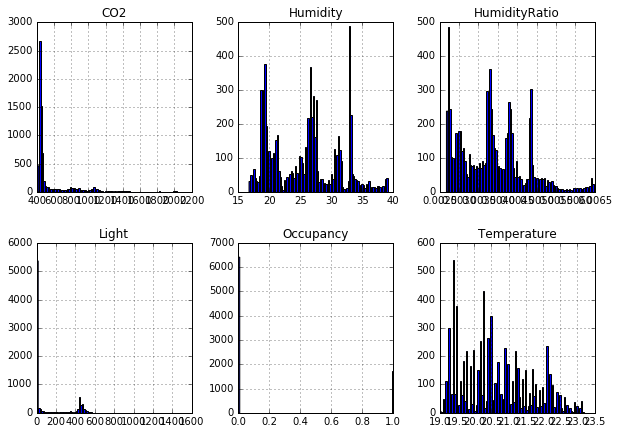

In [20]:
hists = occupancy.hist(bins=100, layout=(2, 3), figsize=(10,7))

## Preparing the pipeline

After inspecting the data we wish to do the following:

* Temperature - Standard scaling
* Humidity - Max-abs scaling
* Light - Binarizing
* CO2 - Binarizing
* HumidityRatio - Max-abs scaling

For that we write the relevant FunctionTransformers and their corresponding functions:

In [44]:
def get_cols_4_ss(df):
    return df[['Temperature']]

ss_selector = FunctionTransformer(func=get_cols_4_ss, validate=False)

In [45]:
def get_cols_4_mas(df):
    return df[['Humidity', 'HumidityRatio']]

mas_selector = FunctionTransformer(func=get_cols_4_mas, validate=False)

In [46]:
def get_light(df):
    return df[['Light']]

light_selector = FunctionTransformer(func=get_light, validate=False)

In [47]:
def get_co2(df):
    return df[['CO2']]

co2_selector = FunctionTransformer(func=get_co2, validate=False)

> **NOTE:** 'ss' stands for 'standard scaler', 'mas' for 'max-abs-scaler', and 'bin' for 'binarizer'.

> **NOTE:** The argument _validate_ has to be set to _False_.

In [48]:
ss_pipeline = Pipeline([('ss_selector', ss_selector), 
                        ('ss', StandardScaler())])
mas_pipeline = Pipeline([('mas_selector', mas_selector), 
                         ('mas', MaxAbsScaler())])
light_pipeline = Pipeline([('light_selector', light_selector), 
                           ('light_bin', Binarizer())])
co2_pipeline = Pipeline([('co2_selector', co2_selector), 
                         ('co2_bin', Binarizer())])

In [49]:
trans_pipeline = FeatureUnion([('ss_pipeline', ss_pipeline), 
                               ('mas_pipeline', mas_pipeline), 
                               ('light_pipeline', light_pipeline), 
                               ('co2_pipeline', co2_pipeline)])

> **NOTE:** There are conveniency functions called _make_\__pipeline()_ and _make_\__union()_ that create objects assiging each step a name equivalent to the step object name.

In [52]:
prepared_train = trans_pipeline.fit_transform(X_train)
prepared_train

array([[ 0.71277489,  0.54061481,  0.51188084,  1.        ,  1.        ],
       [ 0.47675725,  0.64165655,  0.5992115 ,  0.        ,  1.        ],
       [-0.45747928,  0.67150252,  0.59136535,  1.        ,  1.        ],
       ..., 
       [ 0.2702418 ,  0.51128012,  0.47070884,  0.        ,  1.        ],
       [ 0.66360455,  0.50361092,  0.4752034 ,  1.        ,  1.        ],
       [ 1.46016411,  0.55831789,  0.55402376,  1.        ,  1.        ]])

Finally, we add a decision-tree classifier as the last step of the full pipeline.

In [54]:
dt_clf = DecisionTreeClassifier()

In [56]:
dt_pipeline = Pipeline([('trans_pipeline', trans_pipeline), 
                          ('dt_clf', dt_clf)])
lr_pipeline

## Modelling

In [57]:
full_pipeline.fit(X_train, y_train)
y_train_pred = full_pipeline.predict(X_train)
y_test_pred = full_pipeline.predict(X_test)

In [58]:
f1_score(y_train, y_train_pred)

0.99541857559350266

In [59]:
f1_score(y_test, y_test_pred)

0.96121097445600756

# Inheritance from base estimator

In [60]:
from sklearn.base import BaseEstimator

In [63]:
class my_estimator(BaseEstimator):
    def __init__(self, clf1, clf2, th):
        self.clf1 = clf1
        self.clf2 = clf2
    def fit(self, X, y=None):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        return self
    def predict(self, X):
        y_pred1 = self.clf1.predict(X)
        y_pred2 = self.clf2.predict(X)
        y_pred = (y_pred1 + y_pred2) / 2.0
        y_pred[y_pred > 800] = th
        return y_pred

In [64]:
dt_clf1 = DecisionTreeClassifier(max_depth=10)
dt_clf2 = DecisionTreeClassifier(max_depth=2)

In [67]:
my_voter = my_estimator(dt_clf1, dt_clf2)
my_voter.fit(X_train, y_train)

my_estimator(clf1=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       clf2=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))

In [68]:
my_voter.predict(X_train)

array([ 1.,  0.,  0., ...,  0.,  1.,  1.])

In [ ]:
DecisionTreeClassifier().fit().predict()

# Example for selector transfomer

In [1]:
from sklearn.base import TransformerMixin

In [3]:
class my_scaler_selector(TransformerMixin):
    def __init__(self, scalers=[], num=0):
        self.scalers = scalers
        self.num = num
    def fit(self, X, y=None):
        self.scalers[self.num].fit(X, y)
        return self
    def transform(self, X):
        return self.scalers[self.num].transform(X)

In [4]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

my_transformer = my_scaler_selector([StandardScaler(), MaxAbsScaler(), MinMaxScaler()], num=0)